# Imports

---


In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, classification_report, f1_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=[FutureWarning])

## Matplotlib & Seaborn Settings

---


In [4]:
mpl.rcParams.update({'font.size': 26})
mpl.rc('figure', figsize=(8, 8))
sns.set(font_scale=2.0)
sns.color_palette("deep")
%matplotlib inline

# ROC Curves

---

Classification methods can output probabilities rather than labels. Let's say we have a classifier that returns scores for ten individuals who might have a disease. The scores range from 0.0 to 1.0. .7 is determined to be the best break point to distinguish between those with the disease and those without. 

In [5]:
values = np.arange(0.05, 1, .1)
y_true = [0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
y_pred = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

df = pd.DataFrame({'Values': values,
                   'y_true': y_true,
                   'y_pred': y_pred})

display(df)

d = {'Pred Negative': ['.05 .15 .25', '.35 .45'],
     'Pred Positive': ['.55 .65', '.75 .85 .95']}

df = pd.DataFrame(data=d, index=['Real Negative', 'Real Positive'])
display(df)

,Values,y_true,y_pred
0,0.05,0,0
1,0.15,0,0
2,0.25,0,0
3,0.35,1,0
4,0.45,1,0
5,0.55,0,1
6,0.65,0,1
7,0.75,1,1
8,0.85,1,1
9,0.95,1,1


,Pred Negative,Pred Positive
Real Negative,.05 .15 .25,.55 .65
Real Positive,.35 .45,.75 .85 .95



1. How do we evaluate and select this threshold? How do we pick a tradeoff value between false positives and false negatives?
2. How do we compare two different classification systems, both of which have a whole range of possible tradeoffs?

The solution is to use the ROC curve, the _Receiver Operating Characteristic_ curve, which has a long history in classification and was initially used in World War II to quantify radar tracking of bombers headed towards England. ROC curves are drawn in terms of the _sensitivity_, otherwise known as the _true positive rate_ or TPR, compared to the _false positive rate_ or FPR, which is 1 - the _specificity_. Both of these metrics measure performance in the real world. We want the classifier to have a _high_ TPR, 1.0 being the best score, and a _low__ FPR, 0.0 being the best score. 



### Binary ROC

---

In `sklearn`, we can use the `roc_curve` function, which computes Receiver operating characteristic curves and is restricted to the binary classification task. The function accepts true binary labels and target scores, which can either be probability estimates of the positive class, confidence values, or non-thresholded measures of decisions (as returned by the `decision_function` on some classifiers. 

How do we make ROC work? There's a single call, `roc_curve` , in the `sklearn.metrics` module that does the heavy lifting after a couple of setup steps. First, let's convert the iris problem into a *binary* classification task to simplify the interpretation of the results. The binary question asks, "Is it *Versicolor*?" The answer is yes or no. Also, we need to invoke the classification scoring mechanism of our classifier so we can tell who is on which side of our prediction bar. Instead of outputting a class like *Versicolor*, we need to know a probability, such as a .7 likelihood of *Versicolor*. We do this by using `predict_proba` instead of the typical `predict` method. `predict_proba` returns probabilities for *False* and *True* in two columns. We are interested in the probability from the *True* column for building the ROC curve.



Size of full dataset: 150
Size of test dataset: 50

accuracy: 0.94

confusion matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


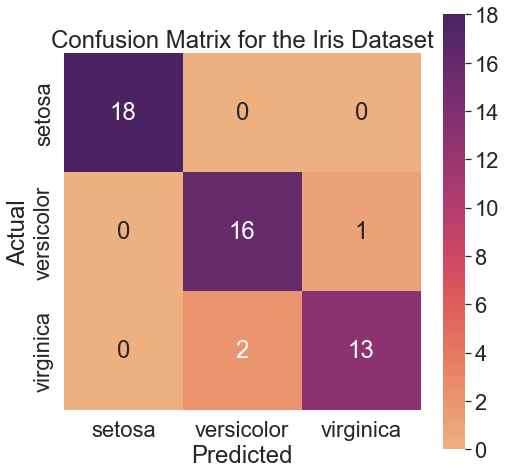

In [ ]:
# Load the iris dataset
iris = datasets.load_iris()

is_versicolor = iris.target == 1

tts_1c = train_test_split(iris.data, is_versicolor,
                          test_size=.33, random_state=21)

(iris_1c_train_ftrs, iris_1c_test_ftrs,
 iris_1c_train_tgt, iris_1c_test_tgt) = tts_1c

# build, fit, predict (probability scores) for NB model
gnb = GaussianNB()

prob_true = (gnb.fit(iris_1c_train_ftrs, iris_1c_train_tgt)
                .predict_proba(iris_1c_test_ftrs)[:, 1])  # [:, 1]=="true"
print("accuracy:", accuracy_score(iris_test_tgt, tgt_preds))
print()
# Print classifier
cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("confusion matrix:", cm, sep="\n")

# Draw confusion matrix using seaborn
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=iris.target_names,
                 yticklabels=iris.target_names,
                 fmt='g', cmap='flare', annot_kws={"size": 24})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for the Iris Dataset')
plt.show()



Most of the FPR values are between 0.0 and 0.2, while the TPR values quickly jump into the range of 0.9 to 1.0. Let's take a look at the calculation of those values. Each point represents a different confusion matrix based on its own unique threshold. The following shows the confusion matrices for the second, fourth, and sixth thresholds labeled in the last graph. Due to zero-based ine to the variable xing, these occur at indices 1, 3, 5and 5 which were assigned to the variable `investigate` in the previous cell. We could have picked any of the eight thresholds that `sklearn` found. Let's look at these values.
title_fmt = "Threshold {}\n~{:5.3f}\nTPR : {:.3f}\nFPR : {:.3f}"

np = ['Negative', 'Positive']
add_args = {'xticklabels': np,
            'yticklabels': np,
            'square': True}
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
for ax, thresh_idx in zip(axes.flat, investigate):
    preds_at_th = prob_true >= thresh[thresh_idx]
    cm = confusion_matrix(iris_1c_test_tgt, preds_at_th)
    sns.heatmap(cm, annot=True, cbar=False, ax=ax, cmap='flare', **add_args)

    ax.set_xlabel('Predicted')
    ax.set_title(title_fmt.format(thresh_idx,
                                  thresh[thresh_idx],
                                  tpr[thresh_idx],
                                  fpr[thresh_idx]))

axes[0].set_ylabel('Actual')
plt.show()

Let's say we want use the confusion matrix to determine how well a classifier identifies sick people.

### AUC: Area-Under-the-(ROC)-Curve

---

How can we summarize an ROC curve as a single value? We answer by calculating the *area under the curve* (AUC) that we've just drawn. The AUC is an *overall* measure of classifier performance at a series of thresholds. The benefit of single-value summaries is that we can easily compute other statistics on them and summarize them graphically. Let's look at several cross-validated AUCs displayed simultaneously on a strip plot.

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
model = sklearn.neighbors.KNeighborsClassifier(3)
cv_auc = sklearn.model_selection.cross_val_score(
    model, iris.data, iris.target == 1, scoring='roc_auc', cv=10)
ax = sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold AUCs')

Many folds return perfect results.

`sklearn.metrics.roc_curve` is ill-equipped to deal with multiclass problems. We can work around this by recoding our tri-class problem into a series of me-versus-the-world or one-versus-rest (OvR) alternatives. OvR means we compare each of the following binary problems: 0 versus [1, 2], 1 versus [0, 2]; , and 2 versus [0, 2]. The difference here is that we do it for all three possibilities. The basic tool to encode these comparisons into our data is `label_binarize` . Let's look at examples 0, 50, and 100 from the original multiclass data.

## Multiclass Learners, One-versus-Rest, and ROC

---

`sklearn.metrics.roc_curve` is ill-equipped to deal with multiclass problems. We can work around this by recoding our tri-class problem into a series of me-versus-the-world or one-versus-rest (OvR) alternatives. OvR means we compare each of the following binary problems: 0 versus [1, 2], 1 versus [0, 2]; , and 2 versus [0, 2]. The difference here is that we do it for all three possibilities. The basic tool to encode these comparisons into our data is `label_binarize` . Let's look at examples 0, 50, and 100 from the original multiclass data.

Therefore, examples 0, 50, and 100 correspond to classes 0, 1, and 2. When we binarize, the classes become:

print("'Multi-label' Encoding")
print(sklearn.preprocessing.label_binarize(
    y=iris.target, classes=[0, 1, 2])[checkout])

import pandas as pd

d = {'0': ['1', '0', '0'],
     '1': ['0', '1', '0'],
     '2': ['0', '0', '1']}

df = pd.DataFrame(data=d, index=['0', '1', '2'])
df

Let's look at another example.

from sklearn.preprocessing import label_binarize
label_binarize(y=[1, 6], classes=[1, 2, 4, 6])

import pandas as pd

d = {'1': ['1', '0'],
     '2': ['0', '0'],
     '4': ['0', '0'],
     '6': ['0', '1']}

df = pd.DataFrame(data=d, index=['1', '6'])
df

The class ordering is preserved:

label_binarize([1, 6], classes=[1, 6, 4, 2])

Binary targets transfrom to a column vector:

sklearn.preprocessing.label_binarize(
    ['yes', 'no', 'no', 'yes'], classes=['no', 'yes'])

These encodings are columns of Boolean flags--yes/no for "Is it class _x_?". The first column answers, "Is it class 0?" and the answers are yes, no, and no. Now, we add a layer of complexity to our classifier. Instead of a *single* classifier, we are going to make one classifier for each target class that was just added, the three new target columns. These become (1) a classifier for class 0 versus the rest, (2) a classifier for class 1 versus the rest, and (3) a classifier for class 2 versus the rest. Then, we can look at the individual performance of the three classifiers.

iris_multi_tgt = sklearn.preprocessing.label_binarize(
    y=iris.target, classes=[0, 1, 2])

# im --> "iris multi"

(im_train_ftrs, im_test_ftrs,
 im_train_tgt, im_test_tgt) = sklearn.model_selection.train_test_split(iris.data,
                                                                       iris_multi_tgt, test_size=.33, random_state=21)

# knn wrapped up in one-versus-rest (3 classifiers)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn = sklearn.multiclass.OneVsRestClassifier(knn)
pred_probs = (ovr_knn.fit(im_train_ftrs, im_train_tgt)
              .predict_proba(im_test_ftrs))

# make ROC plots
fig, ax = plt.subplots(figsize=(8, 4))
for cls in [0, 1, 2]:
    fpr, tpr, _ = sklearn.metrics.roc_curve(im_test_tgt[:, cls],
                                            pred_probs[:, cls])

    label = f'Class {cls} vs Rest (AUC = {sklearn.metrics.auc(fpr,tpr):.2f})'
    ax.plot(fpr, tpr, 'o--', label=label)

ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

# Another Take on Multiclass: One-versus-One

There is another take on dealing with the sometimes negative interaction between multiclass problems and learning systems. In one-versus-rest, we chunk off apples against all other fruit in one grand binary problem. For apples, we create *one* one-versus-rest classifier. Another way to do this is to chuch off apple-versus-banana, apple-versus-orange, and so on. Then, instead of one grand Boolean comparison for apples, we make $n - 1$ comparisons, where  $n$ is the number of classes we have. This alternative is called *one-versus-one*. How do we wrap the one-versus-one winners into a grand winner for making a single prediction? We can take the sums of the individual wins and the class with the biggest number of wins in the class we predict. The one-versus-one wrapper gives us *classification scores* for each individual class. The values are *not* probabilities. We take the index of the maximum classification score to find the single best-predicted class.

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
ovo_knn = sklearn.multiclass.OneVsOneClassifier(knn)
pred_scores = (ovo_knn.fit(iris_train_ftrs, iris_train_tgt)
                      .decision_function(iris_test_ftrs))
df = pd.DataFrame(pred_scores)
df['class'] = df.values.argmax(axis=1)
display(df.head())

Let's put the actual classes beside the one-versus-one classification scores:

# note: ugly way to make column headers
mi = pd.MultiIndex([['Class Indicator', 'Vote'], [0, 1, 2]],
                   [[0]*3+[1]*3, list(range(3)) * 2])
df = pd.DataFrame(np.c_[im_test_tgt, pred_scores], columns=mi)
display(df.head())

Parameters_index = '\n'.join(
    pd.MultiIndex.__doc__.splitlines()).index('Parameters')
print('\n'.join(pd.MultiIndex.__doc__.splitlines())[:])

### DataFrames

There are multiple ways to construct a DataFrame. For instance we can use a dictionary.

import pandas as pd

d = {'Age': ['25', '26'],
     'Name': ['Scott', 'Linda']}

df = pd.DataFrame(data=d)
df

import pandas as pd

d = {'Name': ['Scott', 'Linda'],
     'Age': ['25', '26']}

df = pd.DataFrame(data=d, index=['Subject1', 'Subject2'])
df.index.name = 'Person'
df

import pandas as pd

data = {'Medical Claim': ['Easy to call sick', 'Hard to call sick'],
        'Prediction': ['Easy to predict True', 'Hard to predict False']}

df = pd.DataFrame(data=data, index=['Low', 'High'])
df.index.name = 'Bar'
df

Examples_index = '\n'.join(pd.DataFrame.__doc__.splitlines()).index('Examples')
print('\n'.join(pd.DataFrame.__doc__.splitlines())[Examples_index:])

 

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In the above matrix, the number in the first row and first column indicates that the classifier correctly identified 53, 124 images as non-5s. These are also known as *true negatives*. The remaining 1, 455 images in the first row and second column are known as *false positives* and represent images the classifier incorrectly categorized as 5s, which indeed were not.

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. 
In the above matrix, the number in the first row and first column indicates that the classifier correctly identified 53, 124 images as non-5s. These are also known as *true negatives*. The remaining 1, 455 images in the first row and second column are known as *false positives* and represent images the classifier incorrectly categorized as 5s, which indeed were not. 

Next, in the second row, the number in the first column (949) indicates the images that the classifier incorrectly identified as non-5s. In other words, the images were fives, but the classifier said they were not. These are known as *false negatives*. Finally, the remaining 4, 472 images in the bottom right corner are *true positives*, the fives that the classifier identified correctly. A perfect classifier would have only true positives and true negatives.

Using a confusion matrix, we can compute additional metrics, one of which is the *precision* or the accuracy of the positive predictions. Let's take a look at a few more simple examples.

from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

In the case of a binary classifier, we can extract the true positives, false positives, true negatives, and false negatives.

Not all these metrics are designed for classifiers. How can we identify the scorer used for a particular classifier, say, *k*-NN? You can see the whole output with `help(knn.score).` However, let's trim it down a bit.

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier()

# help(knn.score) # verbose, but complete

# print(knn.score.__doc__.splitlines()[0])
# print('\n--and--\n')
examples_index = "\n".join(np.ravel.__doc__.splitlines()).index('Examples')
print("\n".join(np.ravel.__doc__.splitlines())[examples_index:])
search_word_index = '\n'.join(
    np.ravel.__doc__.splitlines()).index('search_word')
print('\n'.join(np.ravel.__doc__.splitlines())[search_word_index:])

tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
(tn, fp, fn, tp)

Using the 5 and non-5 classifier, we get the following results.

tn, fp, fn, tp = confusion_matrix(y_train_5, y_train_pred).ravel()

## `ravel()`

---
(tn, fp, fn, tp)

Using the 5 and non-5 classifier, we get the following results.

confusion_matrix(y_train_5, y_train_pred)

We can use the $\text{TN}$, $\text{FP}$, $\text{FN}$, and $\text{TP}$ to calculate additional metrics. For instance, **precison** represents the accuracy of the positive predictions and is calculated via the following equation:

$$ \text{precision} = \frac{TP}{TP + FP} $$

Let's calculate the precision.

precision = tp / (tp + fp)
print(f'Precision: {precision:.2f}')

 `numpy.ravel()`

# average is a weighted macro average

# verify sums-across-rows
cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("row counts equal support:", cm.sum(axis=1))
# define reality
act_pos = [1 for _ in range(100)]
act_neg = [0 for _ in range(10000)]
y_true = act_pos + act_neg
# define predictions
pred_pos = [0 for _ in range(5)] + [1 for _ in range(95)]
pred_neg = [1 for _ in range(55)] + [0 for _ in range(9945)]
y_pred = pred_pos + pred_neg
# calculate score
score = f1_score(y_true, y_pred, average='binary')
print(f'F-Measure: {score:.3f}')
Let's confirm this calculation.
# Receiver Operating Characteristic (ROC) with cross-validation

---

The ROC metric can be used to evaluate classifier output quality. The ROC curve typically features the true positive rate on the Y-axis and the false positive rate on the X-axis. The top left corner of the point is the "ideal" point, representing a false positive rate of zero and a true positive rate of one. This result is often unrealistic, but a larger area under the curve is usually better. Also, the "steepness" of the ROC curve is important since it is ideal to maximize the true positive rate while minimizing the false positive rate.

The following shows the ROC response of different datasets created from K-fold cross-validation. Taking all of these cuves we can calculates the mean area under the curve and see the variance of the curve when the training set is split into different subsets, which shows how the classifier output is affected by changes in the training dta, and how different the splits generated by *k*-fold cross-validation afre from one a

# Data IO and generation

---

import numpy as np

from sklearn import datasets

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
X

## Classification and ROC analysis

---

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2,
        color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

How do we compress the rich information in a many-values confusion matrix into simpler values?

In the classification above, we made three mistakes, predicting one Versicolor as Virginica and two Virginica as Versicolor. In our two-class metrics, it was the precision that drew out information about the positive prediction column. When we predict Versicolor, we are correct 16 times and wrong 2. Considering Versicolor by itself, we can calculate something similar to precision giving us $$\frac{16}{18} \approx .89 $$
Similarly, for the Virginica class we get the following. $$\frac{13}{14} \approx .93 $$
Finally, for the Setosa class, we predict $$\frac{18}{18} = 1.0 $$
The mean of $\{\frac{16}{18}, \frac{13}{14}, 1\}$ is about .9392.

from fractions import Fraction
import numpy as np
Versicolor_acc = 16/18
Virginica_acc = 13/14
Setosa_acc = 1
accuracies = [Versicolor_acc, Virginica_acc, Setosa_acc]
accuracies_arr = np.array(accuracies)
avg = np.average(accuracies_arr)
round(avg, 4)
